In [1]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from os.path import join
from keras.layers import Dense
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from keras.models import Sequential
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import RandomUniform

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
data_path = "/kaggle/input/datagtzan-music-speech-collection/"
basic_data = pd.read_csv(data_path+"BasicData.csv")

In [3]:
basic_data.head()

,Filename,Label
0,acomic.wav,Speech
1,ballad.wav,Music
2,acomic2.wav,Speech
3,allison.wav,Speech
4,amal.wav,Speech


In [4]:
VALIDATION_SIZE = 0.25
NUM_CLASSES = 2
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.9851
BATCH_SIZE = 64
EPOCHS = 20

In [5]:
def strided_app(a, L, S):
    """
    Function to split audio as overlapping segments
    L : Window length
    S : Stride (L/stepsize)
    """
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(
        a, shape=(nrows, L), strides=(S*n, n))

In [6]:
def generateDNNData(basic_data, frameS, offset):
    """
    A function to create 1D-DNN features for training the model
    """
    CorpusPath = "/kaggle/input/datagtzan-music-speech-collection/Files/"
    Corpusfiles = basic_data['Filename'].values
    spectrumData = np.empty((0, frameS), int)
    spectrumCol = ['S'+str(i) for i in range(frameS)]
    i = 0
    Fcol = []

    for file in tqdm(Corpusfiles):
        i += 1
        x, Fs = librosa.load(CorpusPath+file)
        segments = strided_app(x, L=frameS, S=offset)
        for _ in range(64):
            ids = np.random.randint(10, size=2)
            for segment in segments[ids, :]:
                Fcol.append(file)
                row = np.abs(np.fft.fft(segment))  # 256d vector
                spectrumData = np.vstack([spectrumData, row])
    spectrumDF = pd.DataFrame(spectrumData, columns=spectrumCol)
    spectrumDF['Filename'] = Fcol

    master_data = pd.merge(basic_data, spectrumDF, on='Filename')
    master_data.to_csv("master_data.csv", index=False)

In [7]:
generateDNNData(basic_data, frameS=256, offset=64)

100%|██████████| 128/128 [01:01<00:00,  2.07it/s]


In [8]:
data = pd.read_csv("master_data.csv").dropna()
data = data.replace({'Speech': 0, 'Music': 1})
X = data.drop(['Filename', 'Label'], axis=1).values
y = data.loc[:, ['Label']].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=VALIDATION_SIZE,
                                                    shuffle=True)

In [10]:
def myDNN(in_shape):
    """
    A function to create a Deep Neural Network model with custom 
    architecture for speech-music classification
    """
    model = Sequential()

    model.add(Dense(32, activation='relu', input_shape=in_shape))

    model.add(Dense(64, activation='relu', input_shape=in_shape))

    model.add(Dense(128, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001),
                    activation='relu'))

    model.add(Dense(256, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001), 
                    activation='relu'))

    model.add(Dense(512, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001), 
                    activation='relu'))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))

    model.add(tf.keras.layers.Dropout(0.5))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))

    model.add(Dense(NUM_CLASSES, kernel_initializer=RandomUniform(minval=-0.05,
                    maxval=0.05), kernel_regularizer=l2(0.001),
                    activation='softmax'))

    model.compile(optimizer='Adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
dnn_model = myDNN(X_train[0].shape)

In [12]:
class EarlyStopper(Callback):
    """
    A class for early stopper callback for validation accuracy
    """
    def __init__(self, target):
        super(EarlyStopper, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs={}):
        acc = logs['val_accuracy']
        if acc >= self.target:
            self.model.stop_training = True

In [13]:
class microf1_callback(Callback):
    def __init__(self,validation_data):
        self.x_test = validation_data[0]
        self.y_test= validation_data[1]
    
    def on_epoch_end(self, epoch, logs):
        ypred = self.model.predict(self.x_test)
        ylabel_pred = np.argmax(ypred, axis=1)
        y_test_arg = self.y_test
        score = f1_score(y_test_arg, ylabel_pred, average="binary")
        print(' validation f1-score : ', np.round(score, 4))

In [14]:
file_path = "dnn_best_model.hdf5"
checkpoint_callback_1 = ModelCheckpoint(filepath=file_path,
                                      monitor="val_accuracy",
                                      verbose=1,
                                      save_best_only=True,
                                      mode="auto")

early_stopper_callback = EarlyStopper(ACCURACY_THRESHOLD)
f1_history_1 = microf1_callback(validation_data=(X_test, y_test))

log_dir_1 = join("logs", "fits", "dnn_model")
tensorboard_callback_1 = TensorBoard(log_dir=log_dir_1, 
                                     histogram_freq=1,
                                     write_graph=True)

In [15]:
adam_optimizer_1 = Adam(learning_rate=LEARNING_RATE)

In [16]:
dnn_model.compile(optimizer=adam_optimizer_1,
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

In [17]:
history_1 = dnn_model.fit(x=X_train, 
                          y=y_train, 
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          steps_per_epoch=int(np.ceil(X_train.shape[0]/BATCH_SIZE)),
                          validation_data=(X_test, y_test),
                          callbacks=[checkpoint_callback_1, 
                                     early_stopper_callback,
                                     tensorboard_callback_1])

Epoch 1/20
190/192 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.7394
Epoch 1: val_accuracy improved from -inf to 0.91016, saving model to dnn_best_model.hdf5
192/192 [==============================] - 4s 12ms/step - loss: 0.6443 - accuracy: 0.7410 - val_loss: 0.2778 - val_accuracy: 0.9102
Epoch 2/20
186/192 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9482
Epoch 2: val_accuracy improved from 0.91016 to 0.97778, saving model to dnn_best_model.hdf5
192/192 [==============================] - 2s 10ms/step - loss: 0.1806 - accuracy: 0.9484 - val_loss: 0.1061 - val_accuracy: 0.9778
Epoch 3/20
192/192 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9810
Epoch 3: val_accuracy improved from 0.97778 to 0.98242, saving model to dnn_best_model.hdf5
192/192 [==============================] - 2s 10ms/step - loss: 0.0950 - accuracy: 0.9810 - val_loss: 0.0813 - val_accuracy: 0.9824
Epoch 4/20
191/192 [=======================

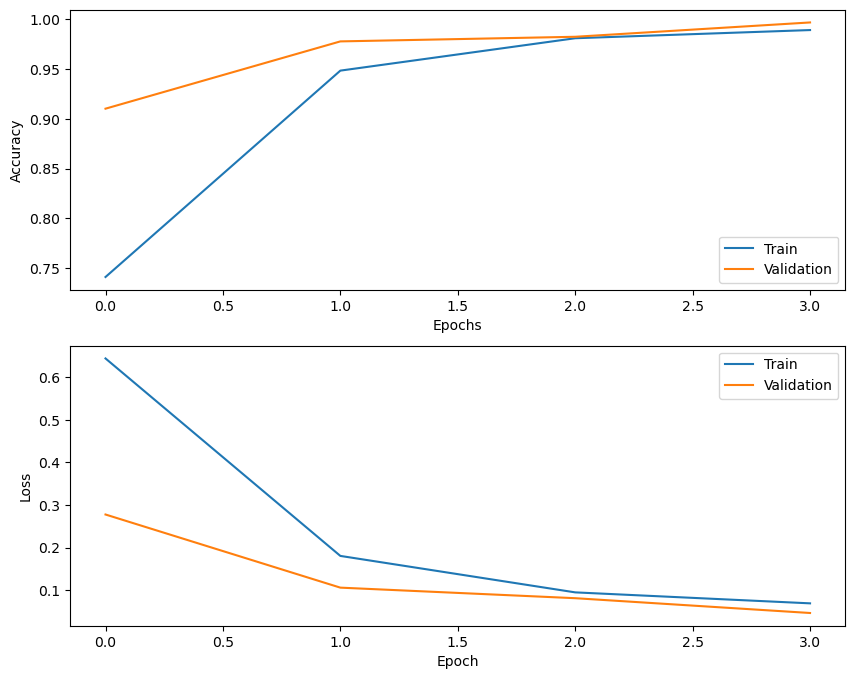

In [18]:
plt.figure(figsize=(10, 8))
plt.subplot(211) 
plt.plot(history_1.history["accuracy"])
plt.plot(history_1.history["val_accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Validation"], loc="lower right")

plt.subplot(212) 
plt.plot(history_1.history['loss'], label='Train')
plt.plot(history_1.history['val_loss'], label='Test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

In [19]:
output_table = PrettyTable(["Model","Accuracy", "Precision", "Recall", "F1-score"])

In [20]:
def predict_with_model(model, X_test, y_test):
    """Function to return train and test scores """
    
    y_test_pred = model.predict(X_test)
    y_test_pred  = np.argmax(y_test_pred, axis=1)
    
    test_acc = np.round(accuracy_score(y_test, y_test_pred),4)
    conf_matrix = np.round(confusion_matrix(y_test, y_test_pred),4)
    precision = np.round(precision_score(y_test, y_test_pred, average='binary'),4)
    recall = np.round(recall_score(y_test, y_test_pred, average='binary'),4)
    f1score = np.round(f1_score(y_test, y_test_pred, average='binary'),4)
    
    return test_acc, conf_matrix, precision, recall, f1score

In [21]:
acc1, cnf1, pre1, recl1, f11 = predict_with_model(dnn_model,
                                                  X_test,
                                                  y_test)
output_table.add_row(["DNN Model",acc1, pre1, recl1, f11])

128/128 [==============================] - 0s 3ms/step


In [22]:
print(output_table)

+-----------+----------+-----------+--------+----------+
|   Model   | Accuracy | Precision | Recall | F1-score |
+-----------+----------+-----------+--------+----------+
| DNN Model |  0.9968  |   0.9956  | 0.9981 |  0.9968  |
+-----------+----------+-----------+--------+----------+
